## Dose Response Curve Fitting in Python
### Setting up the stage
While I would naturally fit dose-response curves in R using drc, recently I have started using iPython more and more and was wondering : "Can I do curve fitting in Python directly?"

Turns out this is quite easy, although not necessarily well documented. Let's create a toy example and see how things are done using scipy.optimize & pandas

retreived from: https://gist.github.com/yannabraham/5f210fed773785d8b638?permalink_comment_id=1713810#file-doseresponsepython-ipynb 

In [1]:
import pandas as pd
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings

def action_with_warnings():
    warnings.warn("should not appear")

Let's use a 4-parameter sigmoidal function as a starting point:

In [3]:
def ll4(x,b,c,d,e):
    '''This function is basically a copy of the LL.4 function from the R drc package with
     - b: hill slope
     - c: min response
     - d: max response
     - e: EC50'''
    return(c+(d-c)/(1+np.exp(b*(np.log(x)-np.log(e)))))

def pDose(x):
    '''This is just a helper function, to compute easily log transformed concentrations used in drug discovery'''
    return(-np.log10(1e-6*x))

## Generating data

Lets generate a set of basic curves using a range of parameters

In [ ]:
params = [{'compound':'A', 'b':1, 'c':0, 'd':100, 'e':0.4,'startDose':10, 'nDose':8, 'dilution':3},
          {'compound':'B', 'b':0.7, 'c':0, 'd':86, 'e':1.3,'startDose':30, 'nDose':8, 'dilution':3},
          {'compound':'C', 'b':2, 'c':24, 'd':152, 'e':0.02,'startDose':3, 'nDose':8, 'dilution':3}]
paramsCompound = [item['compound'] for item in params]

replicates are generated by adding random noise to the reference curve:

In [ ]:
drData=[]
for curve in params:
    # generate base curve
    curData = pd.DataFrame(data={'compound':curve['compound'],
                                 'dose':curve['startDose']/np.power(curve['dilution'],range(curve['nDose']))})
    curData['logDose'] = pDose(curData.dose)
    curData['response'] = curData.dose.apply(lambda x: ll4(x,*[curve[i] for i in ['b','c','d','e']]))
    # generate replicates
    repData = []
    for i in range(5):
        rep = curData
        rep.response += 0.25*np.random.normal(len(rep.response))
        repData.append(rep.copy())
    repData = pd.concat(repData)
    drData.append(repData)
# assemble data
drData = pd.concat(drData)
drData.head()

## Loading my own data

In [4]:
BaseDir = '/Users/chririn/Documents/Data/colo44/results/'

In [5]:
dfViability = pd.read_csv("{}/viability_scores.csv".format(BaseDir), sep=";", index_col=0)
#dfViability.head()

In [6]:
# Remove the reference compounds for now
#print(sorted(list(set(dfViability["compound"]))))
compoundList = ['5-Fluo', '5Z-7-O', 'ABT-73', 'AMG 23', 'AZD454', 'AZD776', 'AZD805', 'Abemac', 'Afatin', 'BMS-75', 'Crizot', 'Dabraf', 'Encora', 'Gefiti', 'LGK974', 'LY2603', 'Linsit', 'MK-177', 'MK-220', 'Navito', 'Nutlin', 'Olapar', 'Oxalip', 'PD0325', 'PI-103', 'Paclit', 'Palboc', 'Ruxoli', 'SB2167', 'SB5051', 'SN-38', 'Sapiti', 'Taseli', 'Temozo', 'Tramet', 'Velipa', 'Vinore', 'alpeli', 'binime', 'cobime', 'regora', 'tricir', 'triflu', 'vemura']



In [7]:
# Remove the reference compounds for now
dfDMSO = dfViability[dfViability.compound.isin(['[dmso]'])]
dfViability = dfViability[dfViability.compound.isin(compoundList)]
dfViability.dropna(inplace=True)
dfViability.reset_index(drop=False, inplace=True)
#dfViability.head()


In [8]:
# Add the log concentration column
dfViability['logConc'] = pDose(dfViability.conc)
dfViability.head()

,index,conc,compound,cbkid,site,plateWell,Count_nuclei,ObjectNumber_cells,logConc
0,9,0.00833,regora,regorafenib,1,colo44-v1-FA-P017365-CACO2-48h-P1-L1_B04,153.0,52.0,8.079355
1,10,0.00833,regora,regorafenib,2,colo44-v1-FA-P017365-CACO2-48h-P1-L1_B04,168.0,52.0,8.079355
2,11,0.00833,regora,regorafenib,3,colo44-v1-FA-P017365-CACO2-48h-P1-L1_B04,207.0,77.0,8.079355
3,12,0.00833,regora,regorafenib,4,colo44-v1-FA-P017365-CACO2-48h-P1-L1_B04,212.0,81.0,8.079355
4,13,0.00833,regora,regorafenib,5,colo44-v1-FA-P017365-CACO2-48h-P1-L1_B04,183.0,67.0,8.079355


## Fitting the curve
is as simple as

In [ ]:
compoundData = drData.groupby(['compound'])
fitData = []
for name,group in compoundData:
    fitCoefs, covMatrix = opt.curve_fit(ll4, group.dose, group.response)
    resids = group.response-group.dose.apply(lambda x: ll4(x,*fitCoefs))
    curFit = dict(zip(['b','c','d','e'],fitCoefs))
    curFit['compound']=name
    curFit['residuals']=sum(resids**2)
    fitData.append(curFit)
fitCompound = [ item['compound'] for item in fitData]

In [ ]:
fitTable = pd.DataFrame(fitData).set_index('compound')
fitTable

In [ ]:
fitTable = pd.DataFrame(fitData).set_index('compound')
paramTable = pd.DataFrame(params).set_index('compound')[['b','c','d','e']]
paramTable.columns = ['ref_'+i for i in paramTable.columns]
fitTable.join(paramTable)

In [ ]:
refDose = np.linspace(min(drData.logDose)*0.9,max(drData.logDose)*1.1,256)
refDose = (10**-refDose)*1e6
sns.lmplot(x='logDose',y='response',data=drData,hue='compound',fit_reg=False)
for fit in fitData:
    plt.plot([pDose(i) for i in refDose],[ll4(i,*[fit[i] for i in ['b','c','d','e']]) for i in refDose])

## Plotting my own data

In [9]:
dfDMSO['logConc']  = dfDMSO.conc  * 90
dfDMSO.head()

,conc,compound,cbkid,site,plateWell,Count_nuclei,ObjectNumber_cells,logConc
18,0.1,[dmso],[dmso],1,colo44-v1-FA-P017365-CACO2-48h-P1-L1_B05,193.0,78.0,9.0
19,0.1,[dmso],[dmso],2,colo44-v1-FA-P017365-CACO2-48h-P1-L1_B05,183.0,85.5,9.0
20,0.1,[dmso],[dmso],3,colo44-v1-FA-P017365-CACO2-48h-P1-L1_B05,194.0,74.5,9.0
21,0.1,[dmso],[dmso],4,colo44-v1-FA-P017365-CACO2-48h-P1-L1_B05,141.0,48.0,9.0
22,0.1,[dmso],[dmso],5,colo44-v1-FA-P017365-CACO2-48h-P1-L1_B05,189.0,83.0,9.0


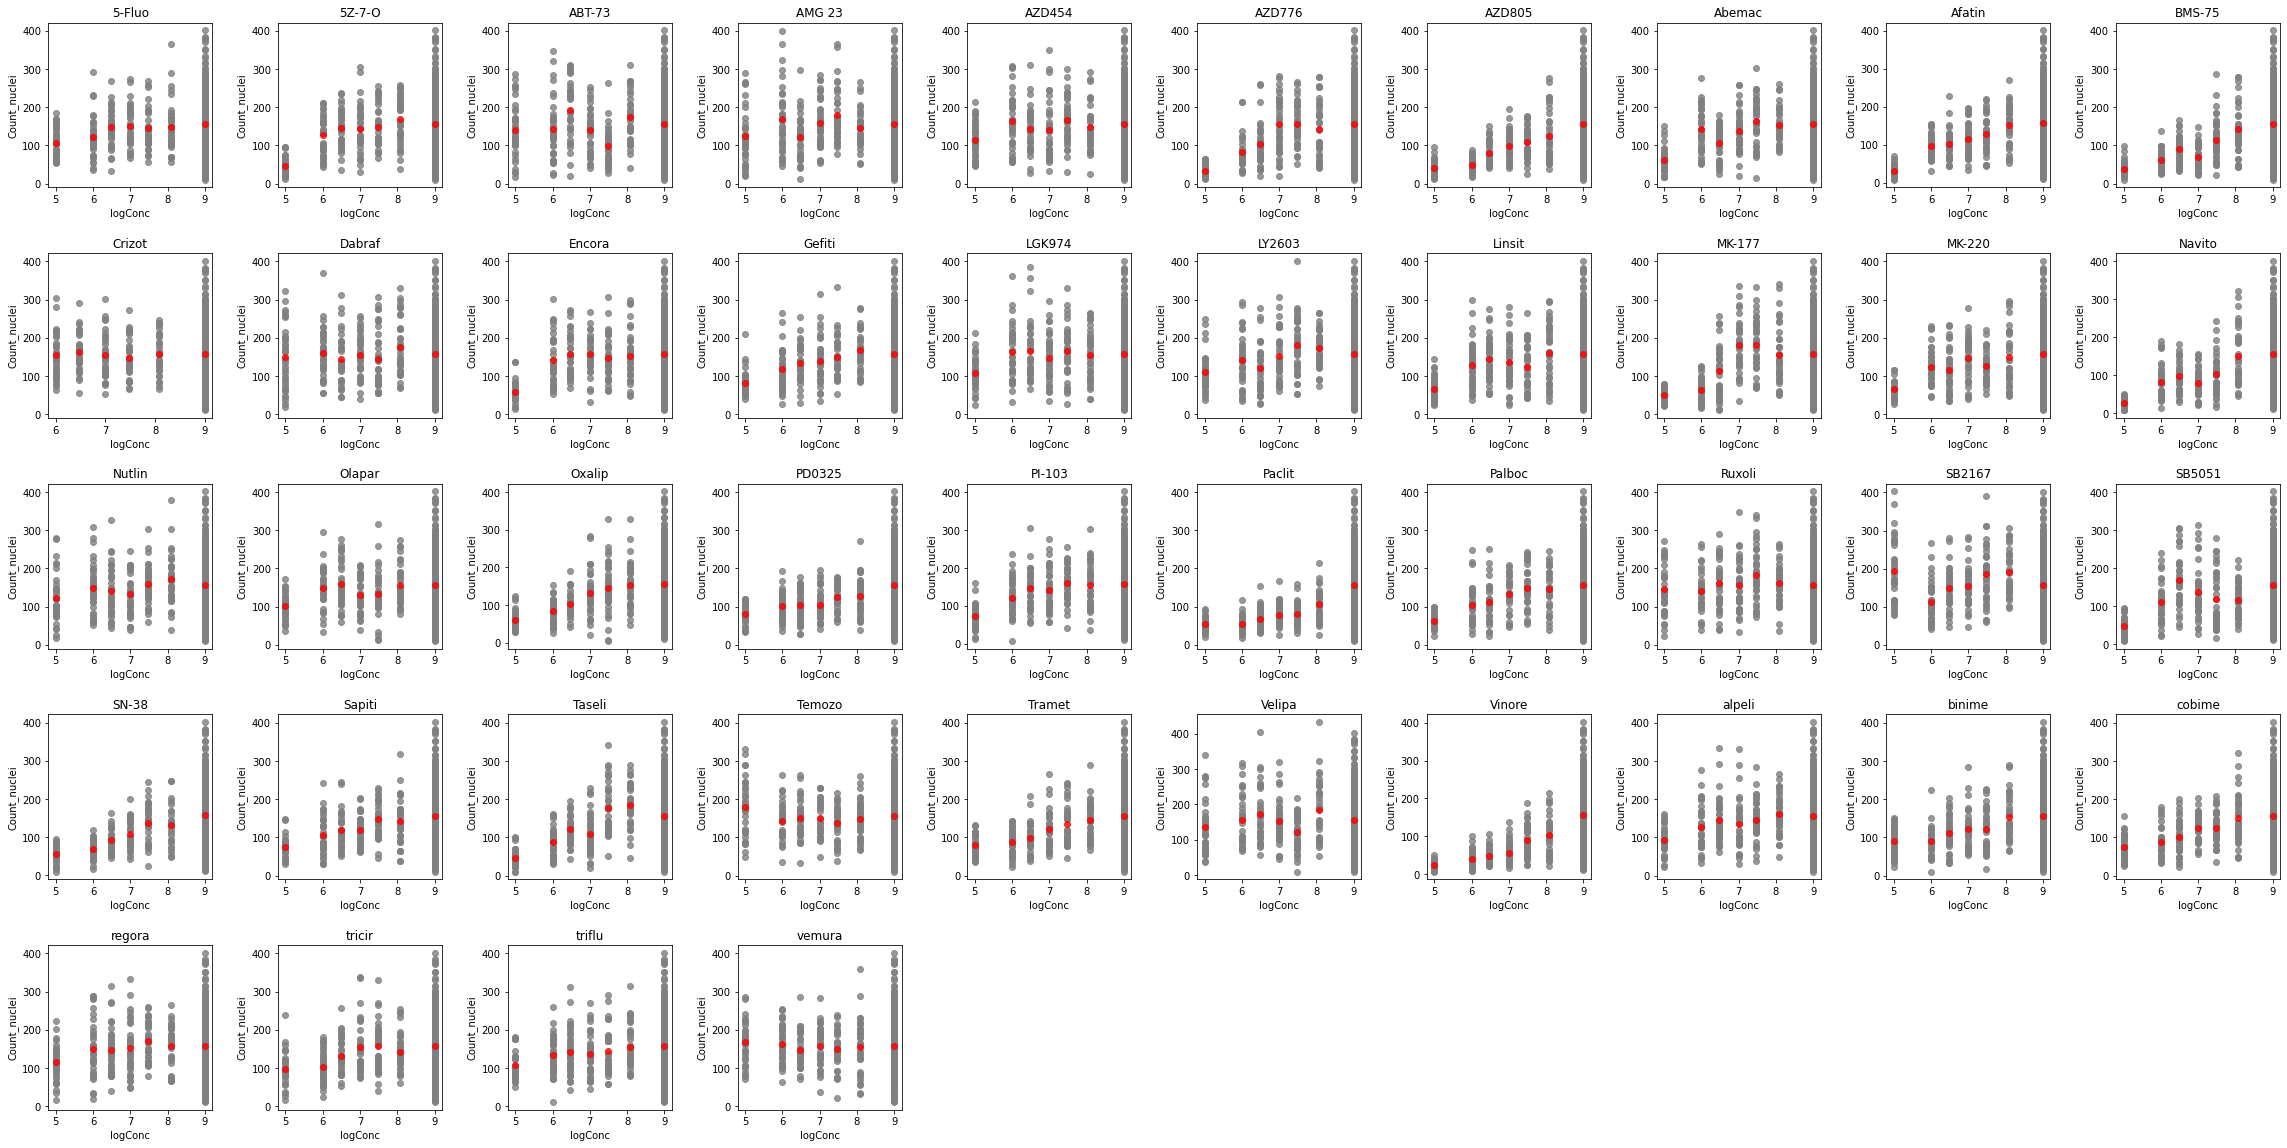

In [10]:
compoundData = dfViability.groupby(['compound'])

nrrow = 5 
nrcol = 10
sp = 1

meanDMSO = dfDMSO[['conc','Count_nuclei', 'ObjectNumber_cells', 'logConc']].mean()

fig = plt.figure(figsize = (40,20))
for compound in compoundData:

    meandata = compound[1].groupby('conc').mean()
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        mean = meandata.append(meanDMSO,ignore_index=True)

    ax = fig.add_subplot(nrrow, nrcol, sp)
    ax.set_title(compound[0])
    sns.regplot(ax=ax, x='logConc',y='Count_nuclei',data=compound[1],color='gray', fit_reg=False) # plot the compounds 
    sns.regplot(ax=ax, x='logConc',y='Count_nuclei',data=dfDMSO,color='gray', fit_reg=False) # add the DMSO data
    sns.regplot(ax=ax, x='logConc',y='Count_nuclei',data=mean,color='red', fit_reg=False) # add the mean data
    sp +=1
plt.subplots_adjust( wspace=0.4, hspace=0.4)

## Fit one compound at a time

In [11]:
cmpd = 1 # Select which compound
name = compoundList[cmpd]
print(name)

5Z-7-O


In [12]:
#compoundData = drData.groupby(['compound'])
fitData = []
for name,group in compoundData:
    fitCoefs, covMatrix = opt.curve_fit(ll4, group.conc, group.Count_nuclei)
    resids = group.Count_nuclei-group.conc.apply(lambda x: ll4(x,*fitCoefs))
    curFit = dict(zip(['b','c','d','e'],fitCoefs))
    curFit['compound']=name
    curFit['residuals']=sum(resids**2)
    fitData.append(curFit)
fitCompound = [ item['compound'] for item in fitData]

/var/folders/bx/43bwk4n57dj9446w1ddn_7t40000gn/T/ipykernel_58976/3180035174.py:7: RuntimeWarning: invalid value encountered in log
  return(c+(d-c)/(1+np.exp(b*(np.log(x)-np.log(e)))))


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

In [13]:
fitTable = pd.DataFrame(fitData).set_index('compound')
fitTable

,b,c,d,e,residuals
compound,,,,,
5-Fluo,5.947048,107.171409,147.565508,0.930612,579850.531002


In [ ]:
params = [{'compound':'5Z-7-O', 'b':1, 'c':0, 'd':100, 'e':0.4,'startDose':10, 'nDose':8, 'dilution':3},]
paramsCompound = [item['compound'] for item in params]

In [14]:
fitTable = pd.DataFrame(fitData).set_index('compound')
paramTable = pd.DataFrame(params).set_index('compound')[['b','c','d','e']]
paramTable.columns = ['ref_'+i for i in paramTable.columns]
fitTable.join(paramTable)

NameError: name 'params' is not defined